In [1]:
import os
import sys
import numpy as np
import torch
from torch import Tensor
from scipy.ndimage import gaussian_filter
from torchvision.transforms.functional import normalize, to_pil_image
from torchvision.transforms.v2 import Compose

import matplotlib.pyplot as plt
from typing import Tuple, Optional

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
print(f"Current directory: {current_dir}; Parent directory: {parent_dir}")
sys.path.insert(0, parent_dir)

import datasets

rng = np.random.default_rng(42)


def plot_img_and_ann(
    img: Tensor,
    ann: Tensor,
    density_map: Optional[Tensor] = None,
    title: Optional[str] = None,
    mean: Tuple[float, float, float] = (0.485, 0.456, 0.406),
    std: Tuple[float, float, float] = (0.229, 0.224, 0.225),
    sigma: float = 4.0,
    # dpi: int = 200,
    alpha: float = 0.2,
    markersize: int = 1,
    markercolor: str = "deeppink",
) -> plt.Figure:
    img = normalize(img, mean=(0., 0., 0.), std = (1. / std[0], 1. / std[1], 1. / std[2]))
    img = normalize(img, mean=(-mean[0], -mean[1], -mean[2]), std=(1., 1., 1.))
    img = to_pil_image(img)

    ann = ann.numpy()

    if density_map is not None:
        density_map = density_map.numpy().squeeze()
        density_map = gaussian_filter(density_map, sigma=sigma)

    # fig, ax = plt.subplots(dpi=dpi)
    # fig.set_dpi(dpi)
    fig, ax = plt.subplots()
    ax.imshow(img)

    if len(ann) > 0:
        ax.scatter(ann[:, 0], ann[:, 1], s=markersize, c=markercolor)
        if density_map is not None:
            ax.imshow(density_map, cmap="jet", alpha=alpha)

    if title is not None:
        ax.set_title(title)
    ax.axis("off")
    fig.tight_layout()
    return fig

crop_size = 672
transforms = Compose([
    datasets.RandomResizedCrop((crop_size, crop_size), scale=(1, 2)),
    datasets.RandomHorizontalFlip(),
    datasets.RandomApply([
        datasets.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.),
        datasets.GaussianBlur(kernel_size=5),
        datasets.PepperSaltNoise(),
    ], p=(1, 1, 0.5)),
    # datasets.RandomGrayscale(p=0.1),
])

Current directory: /Users/yiming/Documents/EBC-ZIP/notebooks; Parent directory: /Users/yiming/Documents/EBC-ZIP


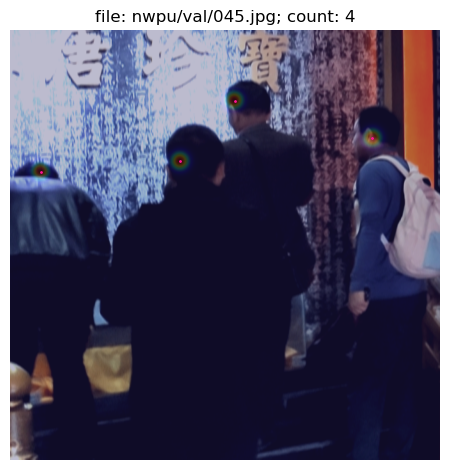

In [2]:
dataset_name = "nwpu"
split = "val"

dataset = datasets.Crowd(
    dataset_name,
    split=split,
    transforms=transforms,
    sigma=8,
    return_filename=True,
)
idx = rng.integers(0, len(dataset))
img, ann, density_map, file_path = dataset[idx]
img = img.squeeze(0)
ann = ann[0]
density_map = density_map.squeeze(0)
file_path = file_path[0]
file_name = os.path.basename(file_path)
fig = plot_img_and_ann(img, ann, density_map, f"file: {dataset_name}/{split}/{file_name}; count: {len(ann)}")

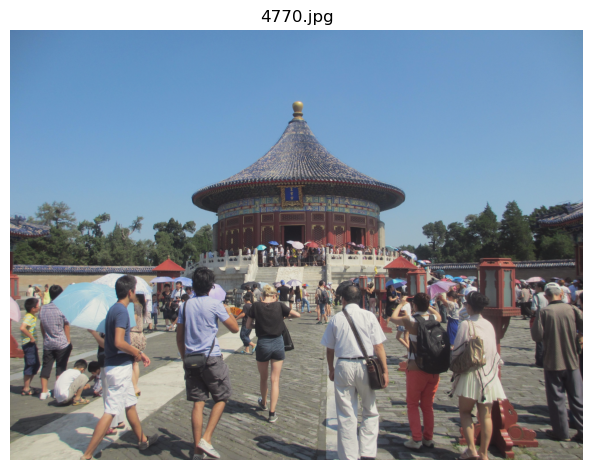

In [3]:
dataset = datasets.NWPUTest(
    transforms=None,
    return_filename=True,
)
idx = rng.integers(0, len(dataset))
img, file_path = dataset[idx]
file_name = os.path.basename(file_path)
fig = plot_img_and_ann(img, torch.tensor([], dtype=torch.float32), None, file_name)